# Probe Results Analysis

This notebook replicates the functionality of `scripts/plot_probes.py` for analyzing probe performance across layers.

In [11]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import re
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [12]:
# Configuration - Update these paths
RESULTS_DIR = "../results/week-31"  # Update this path to your results directory
TAXONOMY_FILE = "../dataset/mcrae-x-things-taxonomy-simp.json"  # Update this path
SAVE_PLOTS = True  # Set to True if you want to save plots
SAVE_DIR = "../plots/notebook_analysis"  # Directory to save plots
METRICS = ["f1"]  # Metrics to analyze

In [13]:
def load_results(results_dir):
    """Load all probe result files."""
    results = {}

    # Look for probe result files
    pattern = str(Path(results_dir) / "probe_results_logistic_*.json")
    files = glob.glob(pattern)

    for file_path in files:
        filename = Path(file_path).name

        # Extract layer from filename
        if "last" in filename:
            layer = "last"
        else:
            # Try to find number in filename
            numbers = re.findall(r"\d+", filename)
            if numbers:
                layer = int(numbers[-1])  # Take the last number
            else:
                continue  # Skip if can't find layer

        with open(file_path, "r") as f:
            data = json.load(f)

        results[layer] = data
        print(f"Loaded {filename} -> layer {layer}")

    return results


def load_taxonomy(taxonomy_file):
    """Load taxonomy file."""
    with open(taxonomy_file, "r") as f:
        return json.load(f)


def extract_layer_performance(results, metric="f1"):
    """Extract performance metrics for each layer."""
    layer_data = []

    for layer, data in results.items():
        individual_results = data["individual_results"]

        # Get all scores for this metric
        scores = [r[f"mean_{metric}"]*100 for r in individual_results]  # Convert to percentage

        layer_data.append(
            {
                "layer": layer,
                "mean": np.mean(scores),
                "std": np.std(scores),
                "median": np.median(scores),
                "min": np.min(scores),
                "max": np.max(scores),
                "n_attributes": len(scores),
            }
        )

    # Sort by layer (numeric first, then 'last')
    def sort_key(item):
        if item["layer"] == "last":
            return 999
        else:
            return item["layer"]

    layer_data.sort(key=sort_key)
    return layer_data

In [14]:
# Load results and taxonomy
print(f"Loading results from: {RESULTS_DIR}")
results = load_results(RESULTS_DIR)

if not results:
    print("No results found! Please check the RESULTS_DIR path.")
else:
    print(f"Found {len(results)} layers: {sorted(results.keys())}")

# Load taxonomy
try:
    taxonomy = load_taxonomy(TAXONOMY_FILE)
    print(f"Loaded taxonomy with {len(taxonomy)} attributes")
    print(f"Categories: {sorted(set(taxonomy.values()))}")
except Exception as e:
    print(f"Could not load taxonomy: {e}")
    taxonomy = {}

# Create save directory if needed
if SAVE_PLOTS:
    Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
    print(f"Plots will be saved to: {SAVE_DIR}")

Loading results from: ../results/week-31
Loaded probe_results_logistic_1.json -> layer 1
Loaded probe_results_logistic_0.json -> layer 0
Loaded probe_results_logistic_11.json -> layer 11
Loaded probe_results_logistic_7.json -> layer 7
Loaded probe_results_logistic_6.json -> layer 6
Loaded probe_results_logistic_10.json -> layer 10
Loaded probe_results_logistic_9.json -> layer 9
Loaded probe_results_logistic_13.json -> layer 13
Loaded probe_results_logistic_5.json -> layer 5
Loaded probe_results_logistic_4.json -> layer 4
Loaded probe_results_logistic_12.json -> layer 12
Loaded probe_results_logistic_8.json -> layer 8
Loaded probe_results_logistic_3.json -> layer 3
Loaded probe_results_logistic_2.json -> layer 2
Found 14 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Loaded taxonomy with 278 attributes
Categories: ['encyclopaedic', 'function', 'sense-non-visual', 'taxonomic', 'visual-colour', 'visual-form_and_surface', 'visual-motion']
Plots will be saved to: ../plots/notebook_a

## 1. Overview Performance Across Layers

Saved plot to: ../plots/notebook_analysis/overview_performance_f1.png


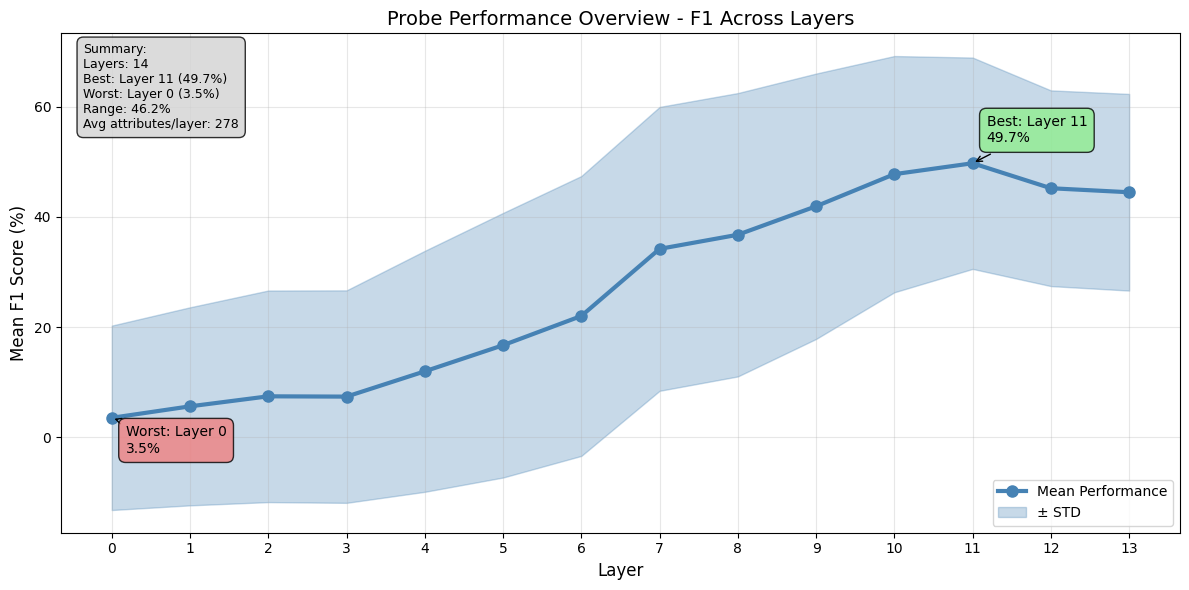


Overview Performance Summary (F1):
Layer    0: 3.5% ± 16.7% (n=278) ⚠️  WORST
Layer    1: 5.6% ± 18.0% (n=278)
Layer    2: 7.4% ± 19.2% (n=278)
Layer    3: 7.4% ± 19.3% (n=278)
Layer    4: 12.0% ± 21.9% (n=278)
Layer    5: 16.7% ± 24.0% (n=278)
Layer    6: 22.0% ± 25.4% (n=278)
Layer    7: 34.2% ± 25.8% (n=278)
Layer    8: 36.7% ± 25.7% (n=278)
Layer    9: 41.9% ± 24.1% (n=278)
Layer   10: 47.7% ± 21.4% (n=278)
Layer   11: 49.7% ± 19.2% (n=278) ⭐ BEST
Layer   12: 45.2% ± 17.8% (n=278)
Layer   13: 44.5% ± 17.8% (n=278)

Performance range: 3.5% - 49.7% (Δ=46.2%)


In [15]:
def overview_performance(results, metric="f1", save_path=None):
    """Plot line plot with mean performance at each layer."""
    # Extract performance data for all layers
    layer_data = extract_layer_performance(results, metric)

    if not layer_data:
        print("No layer data found!")
        return

    # Extract data for plotting
    layers = [d["layer"] for d in layer_data]
    means = [d["mean"] for d in layer_data]
    stds = [d["std"] for d in layer_data]
    n_attributes = [d["n_attributes"] for d in layer_data]

    # Create the plot
    plt.figure(figsize=(12, 6))
    x_pos = range(len(layers))

    # Main line plot
    plt.plot(
        x_pos,
        means,
        "o-",
        linewidth=3,
        markersize=8,
        color="steelblue",
        label="Mean Performance",
    )

    # Error bars (shaded area)
    plt.fill_between(
        x_pos,
        [m - s for m, s in zip(means, stds)],
        [m + s for m, s in zip(means, stds)],
        alpha=0.3,
        color="steelblue",
        label="± STD",
    )

    # Formatting
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel(f"Mean {metric.upper()} Score (%)", fontsize=12)
    plt.title(
        f"Probe Performance Overview - {metric.upper()} Across Layers",
        fontsize=14,
    )
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Set x-axis labels
    plt.xticks(x_pos, [str(l) for l in layers])

    # Add annotations for best and worst layers
    best_idx = np.argmax(means)
    worst_idx = np.argmin(means)

    plt.annotate(
        f"Best: Layer {layers[best_idx]}\n{means[best_idx]:.1f}%",
        xy=(best_idx, means[best_idx]),
        xytext=(10, 15),
        textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
        fontsize=10,
    )

    plt.annotate(
        f"Worst: Layer {layers[worst_idx]}\n{means[worst_idx]:.1f}%",
        xy=(worst_idx, means[worst_idx]),
        xytext=(10, -25),
        textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.8),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
        fontsize=10,
    )

    # Add text box with summary stats
    summary_text = f"""Summary:
Layers: {len(layers)}
Best: Layer {layers[best_idx]} ({means[best_idx]:.1f}%)
Worst: Layer {layers[worst_idx]} ({means[worst_idx]:.1f}%)
Range: {max(means) - min(means):.1f}%
Avg attributes/layer: {np.mean(n_attributes):.0f}"""

    plt.text(
        0.02,
        0.98,
        summary_text,
        transform=plt.gca().transAxes,
        fontsize=9,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8),
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to: {save_path}")

    plt.show()

    # Print summary to console
    print(f"\nOverview Performance Summary ({metric.upper()}):")
    print("=" * 40)
    for i, (layer, mean, std, n_attr) in enumerate(
        zip(layers, means, stds, n_attributes)
    ):
        status = ""
        if i == best_idx:
            status = " ⭐ BEST"
        elif i == worst_idx:
            status = " ⚠️  WORST"
        print(f"Layer {layer:>4}: {mean:.1f}% ± {std:.1f}% (n={n_attr:3d}){status}")

    print(
        f"\nPerformance range: {min(means):.1f}% - {max(means):.1f}% (Δ={max(means)-min(means):.1f}%)"
    )

    return layer_data


# Create overview performance plot
for metric in METRICS:
    save_path = f"{SAVE_DIR}/overview_performance_{metric}.png" if SAVE_PLOTS else None
    layer_data = overview_performance(results, metric=metric, )

## 2. Category Breakdown Analysis

Best performing layer: 11 (F1: 49.7%)
Saved plot to: ../plots/notebook_analysis/category_breakdown_best.png


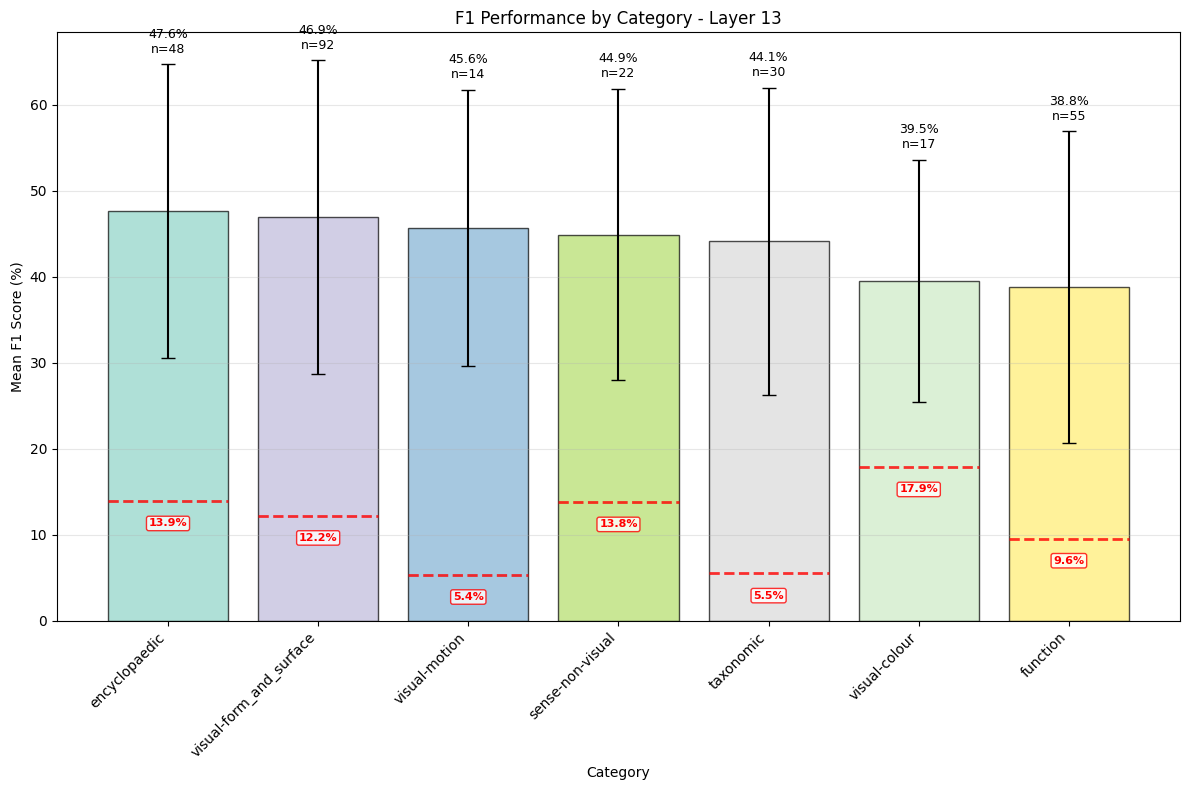


Category Breakdown for Layer 13:
encyclopaedic  : 47.6% ± 17.1% (baseline: 13.9%, n=48)
visual-form_and_surface: 46.9% ± 18.2% (baseline: 12.2%, n=92)
visual-motion  : 45.6% ± 16.1% (baseline: 5.4%, n=14)
sense-non-visual: 44.9% ± 16.9% (baseline: 13.8%, n=22)
taxonomic      : 44.1% ± 17.8% (baseline: 5.5%, n=30)
visual-colour  : 39.5% ± 14.1% (baseline: 17.9%, n=17)
function       : 38.8% ± 18.1% (baseline: 9.6%, n=55)


In [29]:
def category_breakdown(results, layer, taxonomy, metric="f1", save_path=None):
    """Plot performance by semantic category."""
    if layer not in results:
        print(f"Layer {layer} not found in results")
        return

    # Get all attribute scores for this layer
    individual_results = results[layer]["individual_results"]

    # Group scores and baselines by category
    category_scores = {}
    category_baselines = {}
    category_counts = {}
    for result in individual_results:
        attr = result["attribute"]
        score = result[f"mean_{metric}"] * 100  # Convert to percentage
        baseline = result[f"baseline_mean_{metric}"] * 100
        # Get category from taxonomy
        category = taxonomy.get(attr, "unknown")
        if category not in category_scores:
            category_scores[category] = []
            category_baselines[category] = []
            category_counts[category] = 0
        category_scores[category].append(score)
        category_baselines[category].append(baseline)
        category_counts[category] += 1
        
    # Calculate mean score and baseline per category
    category_means = {}
    category_stds = {}
    category_baseline_means = {}
    for cat, scores in category_scores.items():
        category_means[cat] = np.mean(scores)
        category_stds[cat] = np.std(scores)
        category_baseline_means[cat] = np.mean(category_baselines[cat])
        
    # Sort categories by performance
    sorted_categories = sorted(category_means.items(), key=lambda x: x[1], reverse=True)
    categories = [cat for cat, _ in sorted_categories]
    means = [score for _, score in sorted_categories]
    stds = [category_stds[cat] for cat, _ in sorted_categories]
    counts = [category_counts[cat] for cat, _ in sorted_categories]
    baselines = [category_baseline_means[cat] for cat, _ in sorted_categories]
    
    # Create plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    x_pos = range(len(categories))

    bars = plt.bar(
        x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor="black"
    )

    # Add red baseline markers for each category
    for i, baseline in enumerate(baselines):
        plt.plot(
            [i - 0.4, i + 0.4],
            [baseline, baseline],
            color="red",
            linestyle="--",
            linewidth=2,
            alpha=0.8,
        )

        # Add baseline percentage text
        plt.text(
            i,
            baseline - 2,
            f"{baseline:.1f}%",
            color="red",
            fontweight="bold",
            ha="center",
            va="top",
            fontsize=8,
            bbox=dict(
                boxstyle="round,pad=0.2", facecolor="white", edgecolor="red", alpha=0.8
            ),
        )

    plt.xlabel("Category")
    plt.ylabel(f"Mean {metric.upper()} Score (%)")
    plt.title(f"{metric.upper()} Performance by Category - Layer {layer}")
    plt.xticks(x_pos, categories, rotation=45, ha="right")
    plt.grid(True, alpha=0.3, axis="y")

    # Add performance value and count labels on bars
    for i, (bar, count, mean_val) in enumerate(zip(bars, counts, means)):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + stds[i] + 1,
            f"{mean_val:.1f}%\nn={count}",
            ha="center",
            va="bottom",
            fontsize=9,
        )
        
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to: {save_path}")
    plt.show()
    
    # Print detailed breakdown
    print(f"\nCategory Breakdown for Layer {layer}:")
    print("=" * 50)
    for cat, mean_score in sorted_categories:
        std_score = category_stds[cat]
        baseline_score = category_baseline_means[cat]
        count = category_counts[cat]
        print(
            f"{cat:15s}: {mean_score:.1f}% ± {std_score:.1f}% (baseline: {baseline_score:.1f}%, n={count})"
        )
        
    return category_means, category_counts


# Create category breakdown for best and last layers
if taxonomy and results:
    # Find best layer
    layer_data = extract_layer_performance(results, "f1")
    if layer_data:
        best_idx = max(range(len(layer_data)), key=lambda i: layer_data[i]['mean'])
        best_layer = layer_data[best_idx]['layer']
        print(f"Best performing layer: {best_layer} (F1: {layer_data[best_idx]['mean']:.1f}%)")
        
        # Plot for best layer
        save_path = f"{SAVE_DIR}/category_breakdown_best.png" if SAVE_PLOTS else None
        category_breakdown(results, 13, taxonomy, )
        
        # Plot for last layer if different from best
        if "last" in results and best_layer != "last":
            save_path = f"{SAVE_DIR}/category_breakdown_last.png" if SAVE_PLOTS else None
            category_breakdown(results, "last", taxonomy, )
else:
    print("Skipping category analysis - no taxonomy or results found")

## 3. Performance Curves by Category

Saved plot to: ../plots/notebook_analysis/performance_curves.png


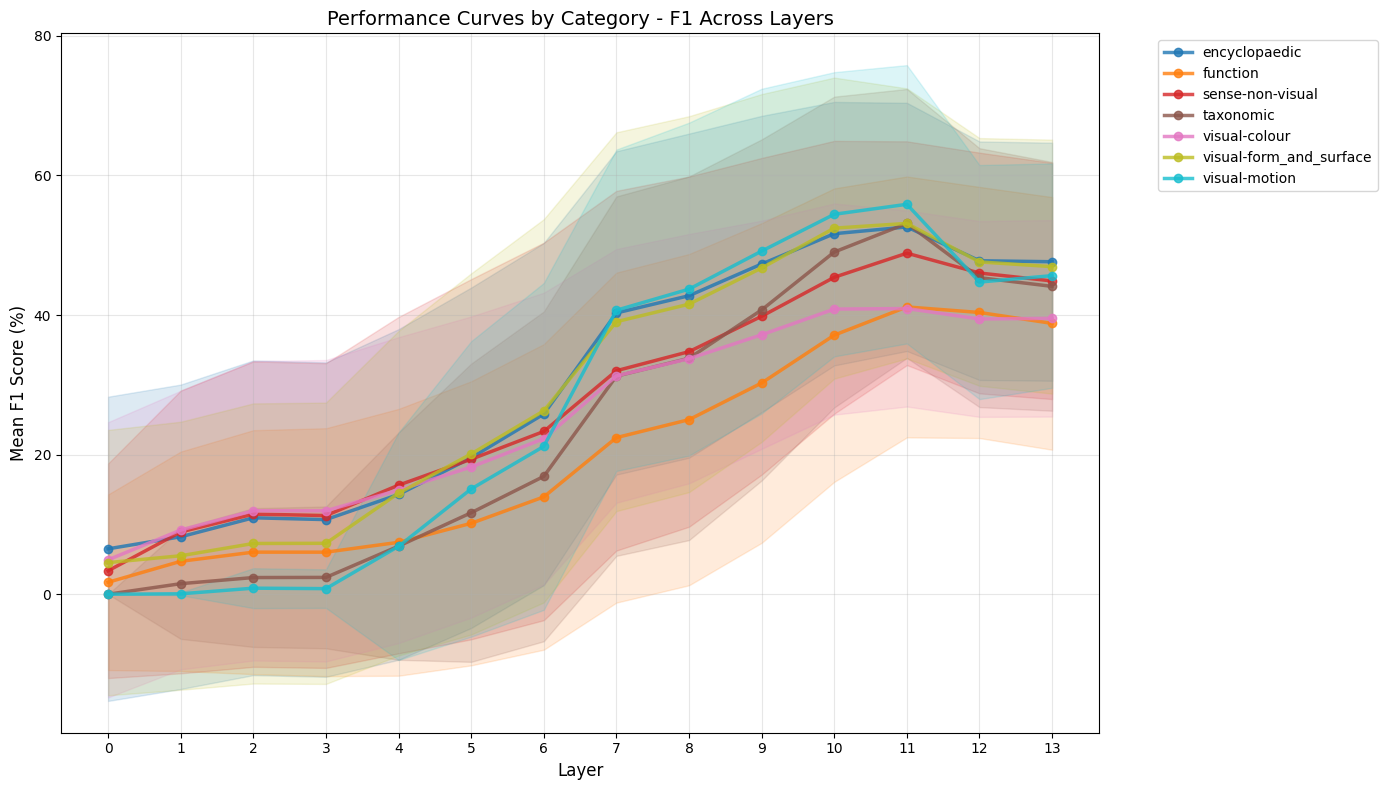


Performance Curves Analysis (F1):
Categories ranked by peak performance layer:
  encyclopaedic  : Peak at layer   11 (52.6%, n=48)
  function       : Peak at layer   11 (41.2%, n=55)
  sense-non-visual: Peak at layer   11 (48.9%, n=22)
  taxonomic      : Peak at layer   11 (53.1%, n=30)
  visual-colour  : Peak at layer   11 (40.9%, n=17)
  visual-form_and_surface: Peak at layer   11 (53.1%, n=92)
  visual-motion  : Peak at layer   11 (55.9%, n=14)


In [33]:
def performance_curves(results, taxonomy, categories=None, metric="f1", save_path=None):
    """Plot performance curves by category across layers."""
    if not categories:
        # Get all unique categories from taxonomy
        categories = list(set(taxonomy.values()))
        categories.sort()

    # Initialize data structure for each category
    category_data = {cat: [] for cat in categories}

    # Sort layers properly
    sorted_layers = sorted(results.keys(), key=lambda x: 999 if x == "last" else x)

    # For each layer, calculate performance by category
    for layer in sorted_layers:
        if layer not in results:
            continue

        individual_results = results[layer]["individual_results"]

        # Group scores by category for this layer
        layer_category_scores = {cat: [] for cat in categories}

        for result in individual_results:
            attr = result["attribute"]
            score = result[f"mean_{metric}"] * 100  # Convert to percentage
            category = taxonomy.get(attr, "unknown")

            if category in layer_category_scores:
                layer_category_scores[category].append(score)

        # Calculate mean for each category in this layer
        for cat in categories:
            if layer_category_scores[cat]:  # If category has attributes in this layer
                mean_score = np.mean(layer_category_scores[cat])
                std_score = np.std(layer_category_scores[cat])
                n_attrs = len(layer_category_scores[cat])

                category_data[cat].append(
                    {
                        "layer": layer,
                        "mean": mean_score,
                        "std": std_score,
                        "n_attributes": n_attrs,
                    }
                )

    # Filter categories that have data across layers
    categories_with_data = []
    for cat in categories:
        if len(category_data[cat]) >= 3:  # At least 3 layers with data
            categories_with_data.append(cat)

    if not categories_with_data:
        print("No categories with sufficient data across layers!")
        return

    # Create the plot
    plt.figure(figsize=(14, 8))

    # Color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories_with_data)))

    # Plot each category
    for i, cat in enumerate(categories_with_data):
        data = category_data[cat]
        layers = [d["layer"] for d in data]
        means = [d["mean"] for d in data]
        stds = [d["std"] for d in data]

        # Convert layer names to x positions
        x_positions = []
        for layer in layers:
            if layer == "last":
                x_positions.append(len(sorted_layers) - 1)
            else:
                x_positions.append(sorted_layers.index(layer))

        # Plot line with error bars
        plt.plot(
            x_positions,
            means,
            "o-",
            linewidth=2.5,
            markersize=6,
            color=colors[i],
            label=f"{cat}",
            alpha=0.8,
        )

        # Add error bars (shaded area)
        plt.fill_between(
            x_positions,
            [m - s for m, s in zip(means, stds)],
            [m + s for m, s in zip(means, stds)],
            alpha=0.15,
            color=colors[i],
        )

    # Formatting
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel(f"Mean {metric.upper()} Score (%)", fontsize=12)
    plt.title(
        f"Performance Curves by Category - {metric.upper()} Across Layers",
        fontsize=14,
    )
    plt.grid(True, alpha=0.3)

    # Set x-axis
    x_labels = [str(layer) for layer in sorted_layers]
    plt.xticks(range(len(sorted_layers)), x_labels)

    # Legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to: {save_path}")

    plt.show()

    # Print analysis
    print(f"\nPerformance Curves Analysis ({metric.upper()}):")
    print("=" * 50)

    # Find peak layer for each category
    category_peaks = {}
    for cat in categories_with_data:
        data = category_data[cat]
        if data:
            best_performance = max(data, key=lambda x: x["mean"])
            category_peaks[cat] = {
                "layer": best_performance["layer"],
                "score": best_performance["mean"],
                "n_attrs": best_performance["n_attributes"],
            }

    # Sort categories by their peak performance layer
    sorted_peaks = sorted(
        category_peaks.items(),
        key=lambda x: 999 if x[1]["layer"] == "last" else x[1]["layer"],
    )

    print("Categories ranked by peak performance layer:")
    for cat, peak_info in sorted_peaks:
        print(
            f"  {cat:15s}: Peak at layer {peak_info['layer']:>4} "
            f"({peak_info['score']:.1f}%, n={peak_info['n_attrs']})"
        )

    return category_data, category_peaks


# Create performance curves plot
if taxonomy and results:
    save_path = f"{SAVE_DIR}/performance_curves.png" if SAVE_PLOTS else None
    category_data, category_peaks = performance_curves(results, taxonomy, save_path=save_path)
else:
    print("Skipping performance curves - no taxonomy or results found")

## 4. Individual Attribute Analysis

Saved plot to: ../plots/notebook_analysis/attribute_breakdown_best.png


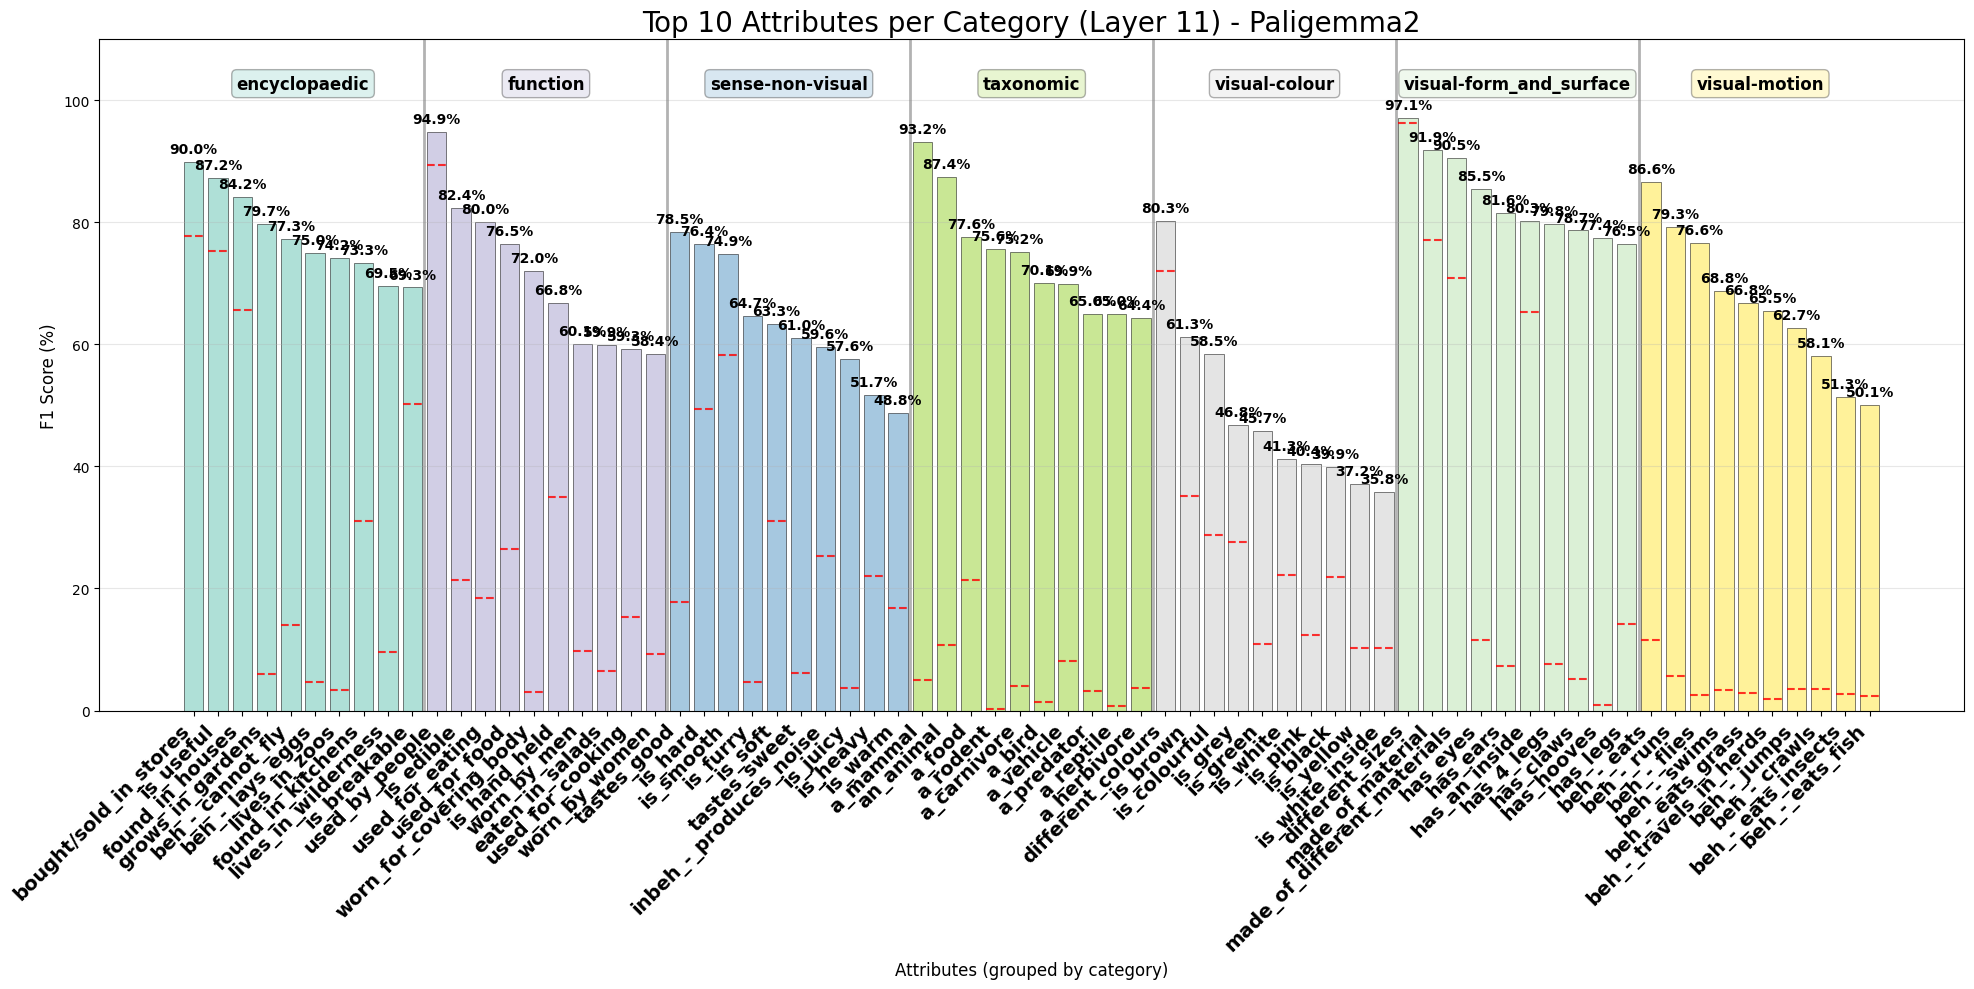


Top 10 attributes per category (Layer 11):

encyclopaedic:
   1. bought/sold_in_stores         : 90.0% (baseline: 77.8%)
   2. is_useful                     : 87.2% (baseline: 75.3%)
   3. found_in_houses               : 84.2% (baseline: 65.7%)
   4. grows_in_gardens              : 79.7% (baseline: 6.0%)
   5. beh_-_cannot_fly              : 77.3% (baseline: 14.1%)
   6. beh_-_lays_eggs               : 75.0% (baseline: 4.6%)
   7. lives_in_zoos                 : 74.2% (baseline: 3.4%)
   8. found_in_kitchens             : 73.3% (baseline: 31.1%)
   9. lives_in_wilderness           : 69.5% (baseline: 9.6%)
  10. is_breakable                  : 69.3% (baseline: 50.3%)

function:
   1. used_by_people                : 94.9% (baseline: 89.4%)
   2. is_edible                     : 82.4% (baseline: 21.4%)
   3. used_for_eating               : 80.0% (baseline: 18.5%)
   4. used_for_food                 : 76.5% (baseline: 26.4%)
   5. worn_for_covering_body        : 72.0% (baseline: 3.1%)
   6

In [18]:
def attribute_breakdown(results, layer, taxonomy, metric="f1", save_path=None, top_n_per_category=10):
    """Plot individual attributes as bars, color-coded by category."""
    if layer not in results:
        print(f"Layer {layer} not found in results")
        return

    # Get all attribute scores for this layer
    individual_results = results[layer]["individual_results"]

    # Create list of (attribute, score, baseline, category) tuples
    attr_data = []
    for result in individual_results:
        attr = result["attribute"]
        score = result[f"mean_{metric}"] * 100  # Convert to percentage
        baseline = result[f"baseline_mean_{metric}"] * 100
        category = taxonomy.get(attr, "unknown")
        attr_data.append((attr, score, baseline, category))

    # Group by category and sort within each category by score descending
    category_groups = {}
    for attr, score, baseline, category in attr_data:
        if category not in category_groups:
            category_groups[category] = []
        category_groups[category].append((attr, score, baseline))

    # Fixed category order for presentation and comparison
    fixed_category_order = ["animal", "bird", "food", "vehicle", "flies", "legs"]
    
    # Add any additional categories not in the fixed order at the end
    all_categories = set(category_groups.keys())
    additional_categories = sorted(all_categories - set(fixed_category_order))
    category_order = [cat for cat in fixed_category_order if cat in category_groups] + additional_categories

    # Sort attributes within each category by score
    for cat in category_groups:
        category_groups[cat].sort(key=lambda x: x[1], reverse=True)

    # Get unique categories and assign colors
    unique_categories = category_order
    category_colors = dict(
        zip(unique_categories, plt.cm.Set3(np.linspace(0, 1, len(unique_categories))))
    )

    # Create plot for top N per category
    category_groups_top = {}
    for cat in category_order:
        if cat in category_groups:
            category_groups_top[cat] = category_groups[cat][:top_n_per_category]

    # Flatten data for plotting
    attributes = []
    scores = []
    baselines = []
    categories = []
    
    for cat in category_order:
        if cat in category_groups_top:
            for attr, score, baseline in category_groups_top[cat]:
                attributes.append(attr)
                scores.append(score)
                baselines.append(baseline)
                categories.append(cat)

    if not attributes:
        print("No attributes to plot")
        return

    # Create the plot
    plt.figure(figsize=(20, 10))
    x_pos = range(len(attributes))
    bar_colors = [category_colors[cat] for cat in categories]

    # Create bars
    bars = plt.bar(
        x_pos,
        scores,
        color=bar_colors,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    # Add percentage labels on top of bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(scores) * 0.01,  # Slight offset above the bar
            f"{score:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Add baseline markers
    for i, baseline in enumerate(baselines):
        plt.plot(
            [i - 0.4, i + 0.4],
            [baseline, baseline],
            color="red",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
        )

    # Add category separators and labels
    current_cat = None
    cat_positions = {}
    
    for i, cat in enumerate(categories):
        if cat not in cat_positions:
            cat_positions[cat] = []
        cat_positions[cat].append(i)
        
        if current_cat is not None and cat != current_cat:
            plt.axvline(x=i-0.5, color="gray", linestyle="-", linewidth=2, alpha=0.6)
        current_cat = cat

    # Add category labels at the top
    y_max = max(scores) * 1.15  # Increased to accommodate percentage labels
    for cat, positions in cat_positions.items():
        center_pos = (min(positions) + max(positions)) / 2
        plt.text(
            center_pos,
            y_max * 0.92,  # Adjusted position
            cat,
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=12,
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor=category_colors[cat],
                alpha=0.3,
                edgecolor="black",
            ),
        )

    # Formatting
    plt.xlabel("Attributes (grouped by category)", fontsize=12)
    plt.ylabel(f"{metric.upper()} Score (%)", fontsize=12)
    plt.title(
        f"Top {top_n_per_category} Attributes per Category (Layer {layer}) - Paligemma2",
        fontsize=20,
    )
    plt.grid(True, alpha=0.3, axis="y")

    # Set x-axis labels
    plt.xticks(x_pos, attributes, rotation=45, ha="right", fontsize=14, fontweight='bold')
    plt.ylim(0, 110)
    
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to: {save_path}")

    plt.show()

    # Print top attributes per category
    print(f"\nTop {top_n_per_category} attributes per category (Layer {layer}):")
    for cat in category_order:
        if cat in category_groups_top and category_groups_top[cat]:
            print(f"\n{cat}:")
            for i, (attr, score, baseline) in enumerate(category_groups_top[cat], 1):
                print(f"  {i:2d}. {attr:<30}: {score:.1f}% (baseline: {baseline:.1f}%)")

    return attr_data


# Create attribute breakdown for best layer
if taxonomy and results and 'best_layer' in locals():
    save_path = f"{SAVE_DIR}/attribute_breakdown_best.png" if SAVE_PLOTS else None
    attribute_breakdown(results, best_layer, taxonomy, )
else:
    print("Skipping attribute breakdown - no taxonomy, results, or best layer identified")

## 5. Summary and Insights

Saved CSV to: ../plots/notebook_analysis/single_category_encyclopaedic_layer13.csv


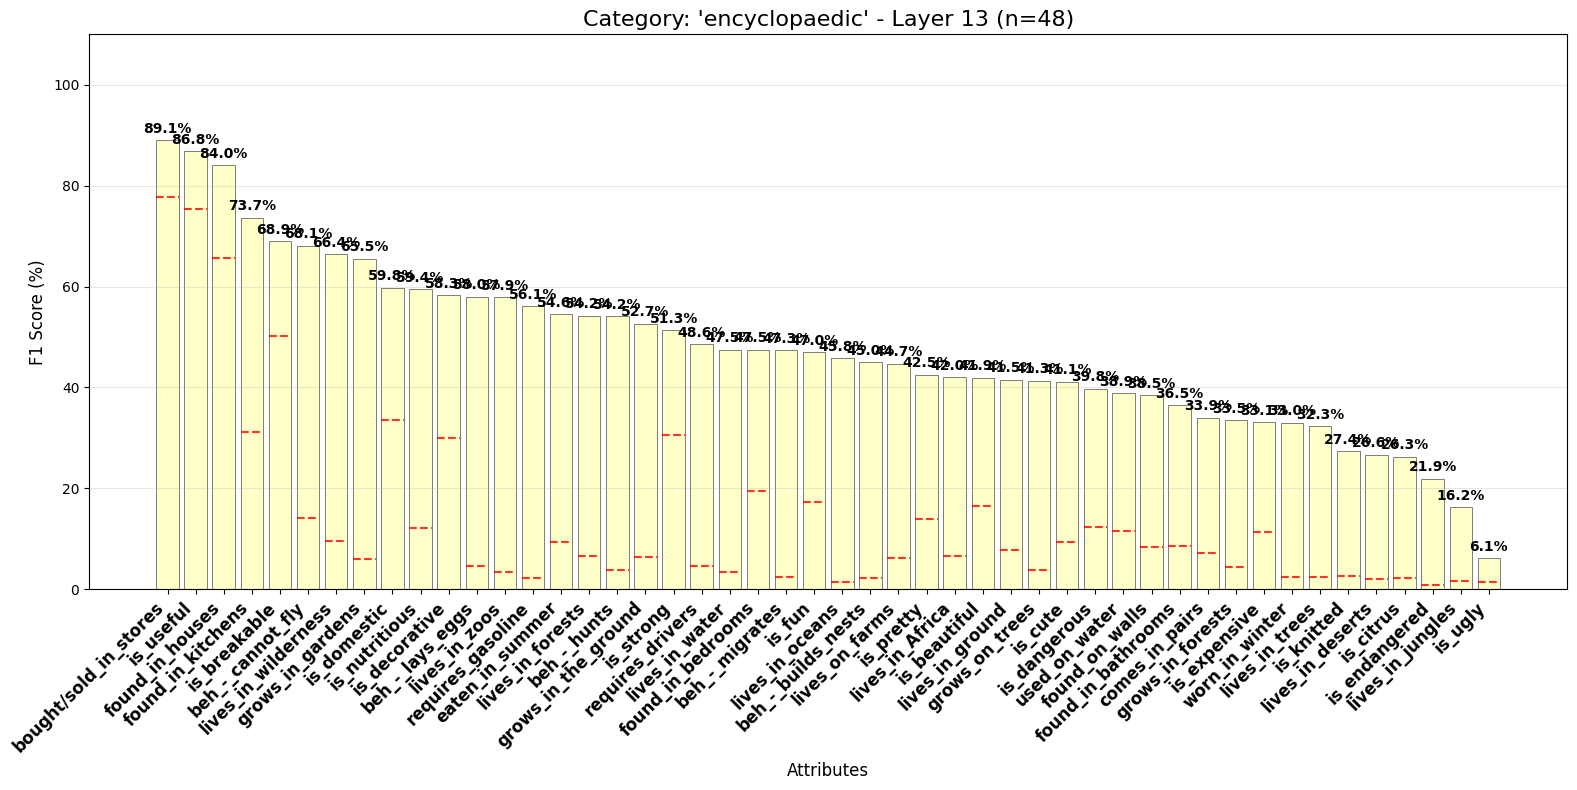


Single Category Analysis: 'encyclopaedic' (Layer 13)
Number of attributes: 48
Mean F1 score: 47.6% ± 17.1%
Mean baseline: 13.9% ± 18.3%
Mean improvement: 33.7% ± 13.1%
Best attribute: bought/sold_in_stores (89.1%)
Worst attribute: is_ugly (6.1%)
Performance range: 6.1% - 89.1%

All attributes in 'encyclopaedic':
   1. bought/sold_in_stores         : 89.1% (baseline: 77.8%, improvement: +11.3%)
   2. is_useful                     : 86.8% (baseline: 75.3%, improvement: +11.5%)
   3. found_in_houses               : 84.0% (baseline: 65.7%, improvement: +18.3%)
   4. found_in_kitchens             : 73.7% (baseline: 31.1%, improvement: +42.6%)
   5. is_breakable                  : 68.9% (baseline: 50.3%, improvement: +18.7%)
   6. beh_-_cannot_fly              : 68.1% (baseline: 14.1%, improvement: +54.1%)
   7. lives_in_wilderness           : 66.4% (baseline: 9.6%, improvement: +56.9%)
   8. grows_in_gardens              : 65.5% (baseline: 6.0%, improvement: +59.5%)
   9. is_domestic      

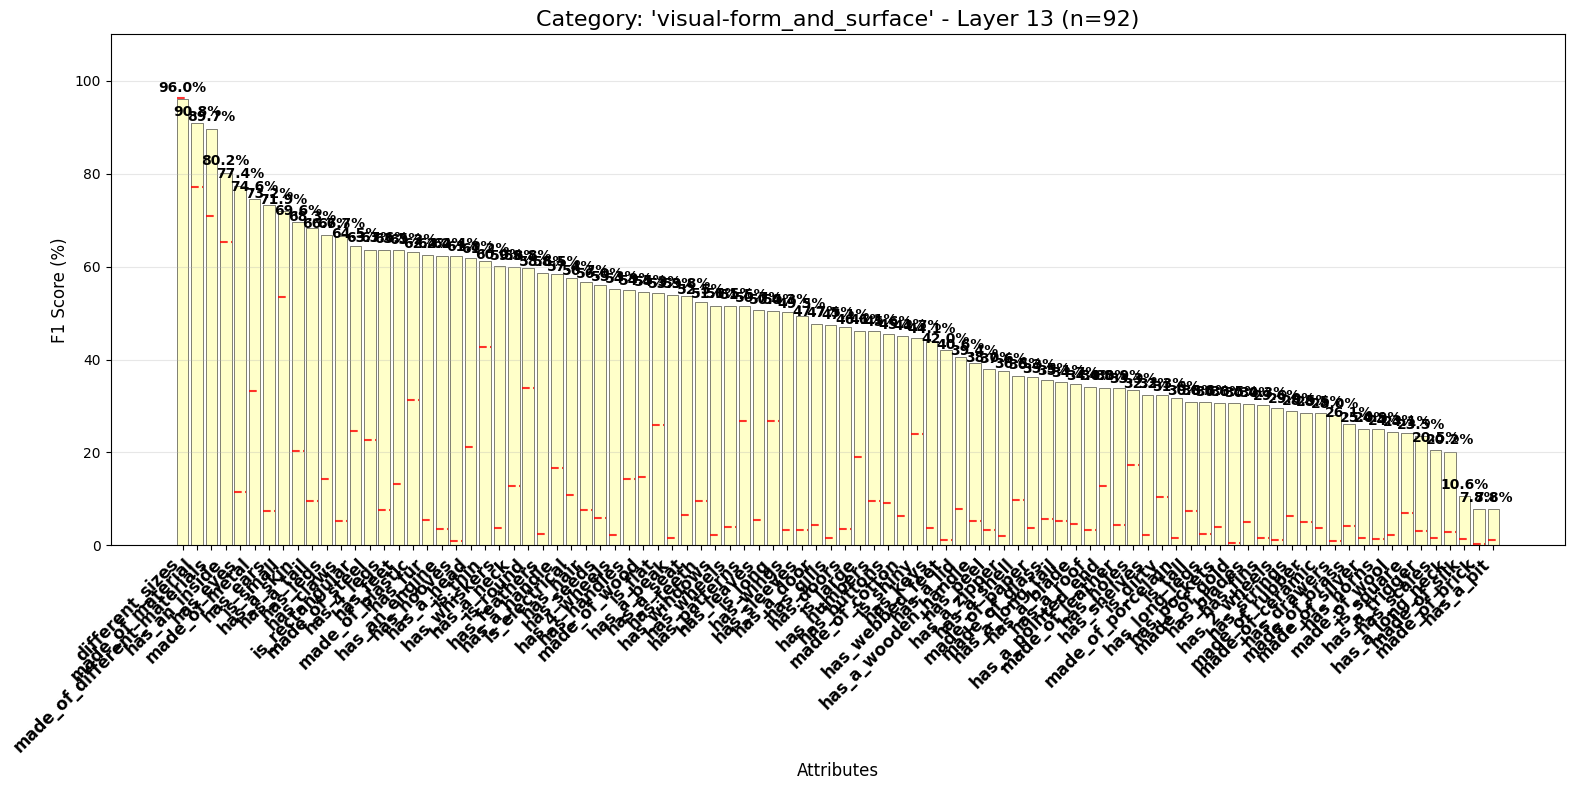


Single Category Analysis: 'visual-form_and_surface' (Layer 13)
Number of attributes: 92
Mean F1 score: 46.9% ± 18.2%
Mean baseline: 12.2% ± 17.2%
Mean improvement: 34.7% ± 14.4%
Best attribute: different_sizes (96.0%)
Worst attribute: has_a_pit (7.8%)
Performance range: 7.8% - 96.0%

All attributes in 'visual-form_and_surface':
   1. different_sizes               : 96.0% (baseline: 96.3%, improvement: -0.3%)
   2. made_of_material              : 90.8% (baseline: 77.1%, improvement: +13.8%)
   3. made_of_different_materials   : 89.7% (baseline: 70.9%, improvement: +18.7%)
   4. has_an_inside                 : 80.2% (baseline: 65.2%, improvement: +15.0%)
   5. has_eyes                      : 77.4% (baseline: 11.6%, improvement: +65.9%)
   6. made_of_metal                 : 74.6% (baseline: 33.1%, improvement: +41.5%)
   7. has_ears                      : 73.2% (baseline: 7.3%, improvement: +65.9%)
   8. is_small                      : 71.9% (baseline: 53.4%, improvement: +18.5%)
   9. h

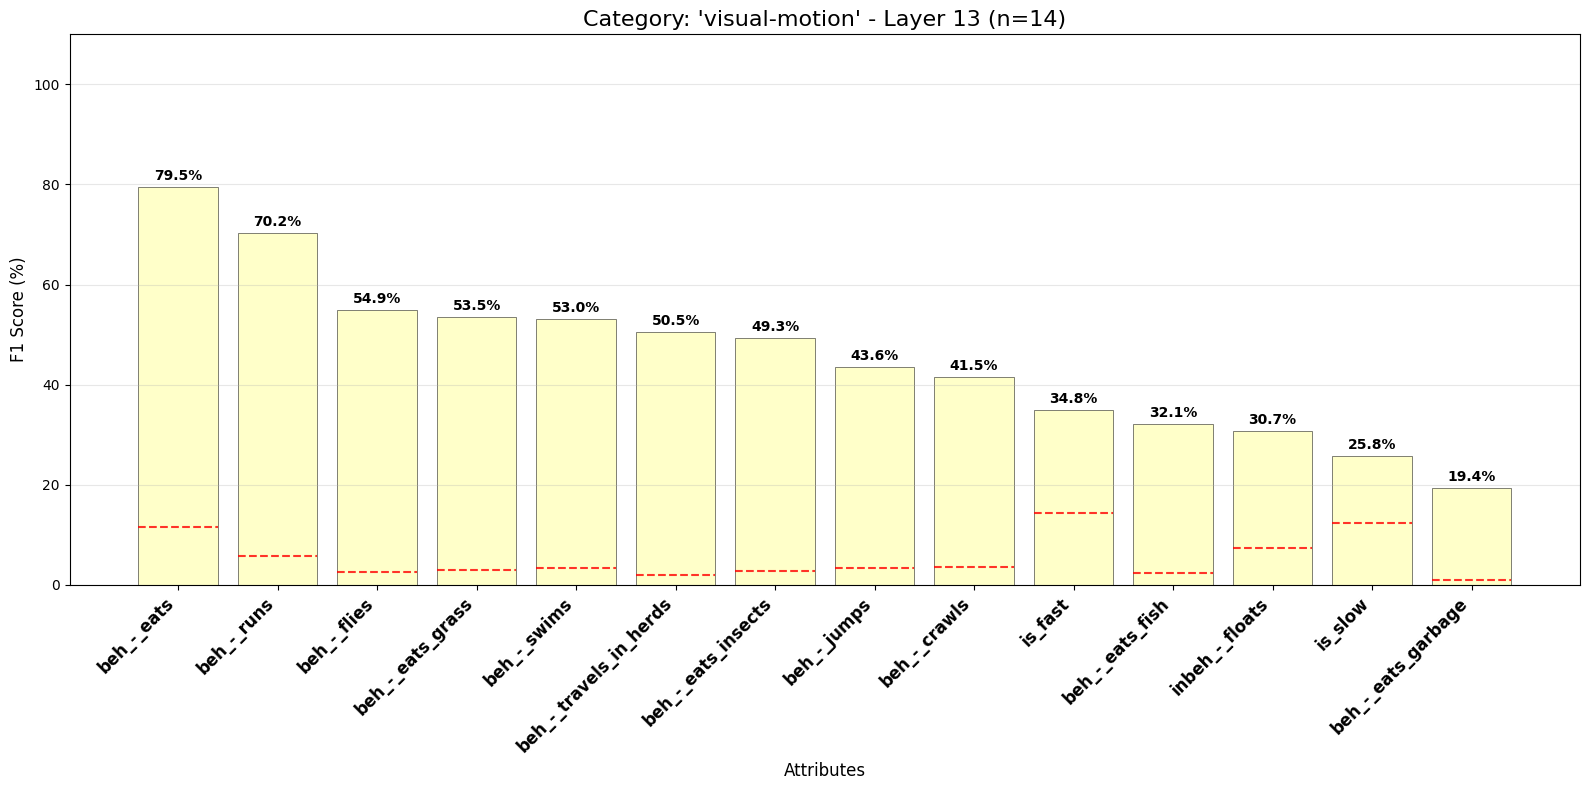


Single Category Analysis: 'visual-motion' (Layer 13)
Number of attributes: 14
Mean F1 score: 45.6% ± 16.1%
Mean baseline: 5.4% ± 4.2%
Mean improvement: 40.3% ± 16.5%
Best attribute: beh_-_eats (79.5%)
Worst attribute: beh_-_eats_garbage (19.4%)
Performance range: 19.4% - 79.5%

All attributes in 'visual-motion':
   1. beh_-_eats                    : 79.5% (baseline: 11.5%, improvement: +68.0%)
   2. beh_-_runs                    : 70.2% (baseline: 5.7%, improvement: +64.5%)
   3. beh_-_flies                   : 54.9% (baseline: 2.6%, improvement: +52.4%)
   4. beh_-_eats_grass              : 53.5% (baseline: 2.9%, improvement: +50.7%)
   5. beh_-_swims                   : 53.0% (baseline: 3.4%, improvement: +49.7%)
   6. beh_-_travels_in_herds        : 50.5% (baseline: 1.9%, improvement: +48.6%)
   7. beh_-_eats_insects            : 49.3% (baseline: 2.8%, improvement: +46.6%)
   8. beh_-_jumps                   : 43.6% (baseline: 3.5%, improvement: +40.1%)
   9. beh_-_crawls          

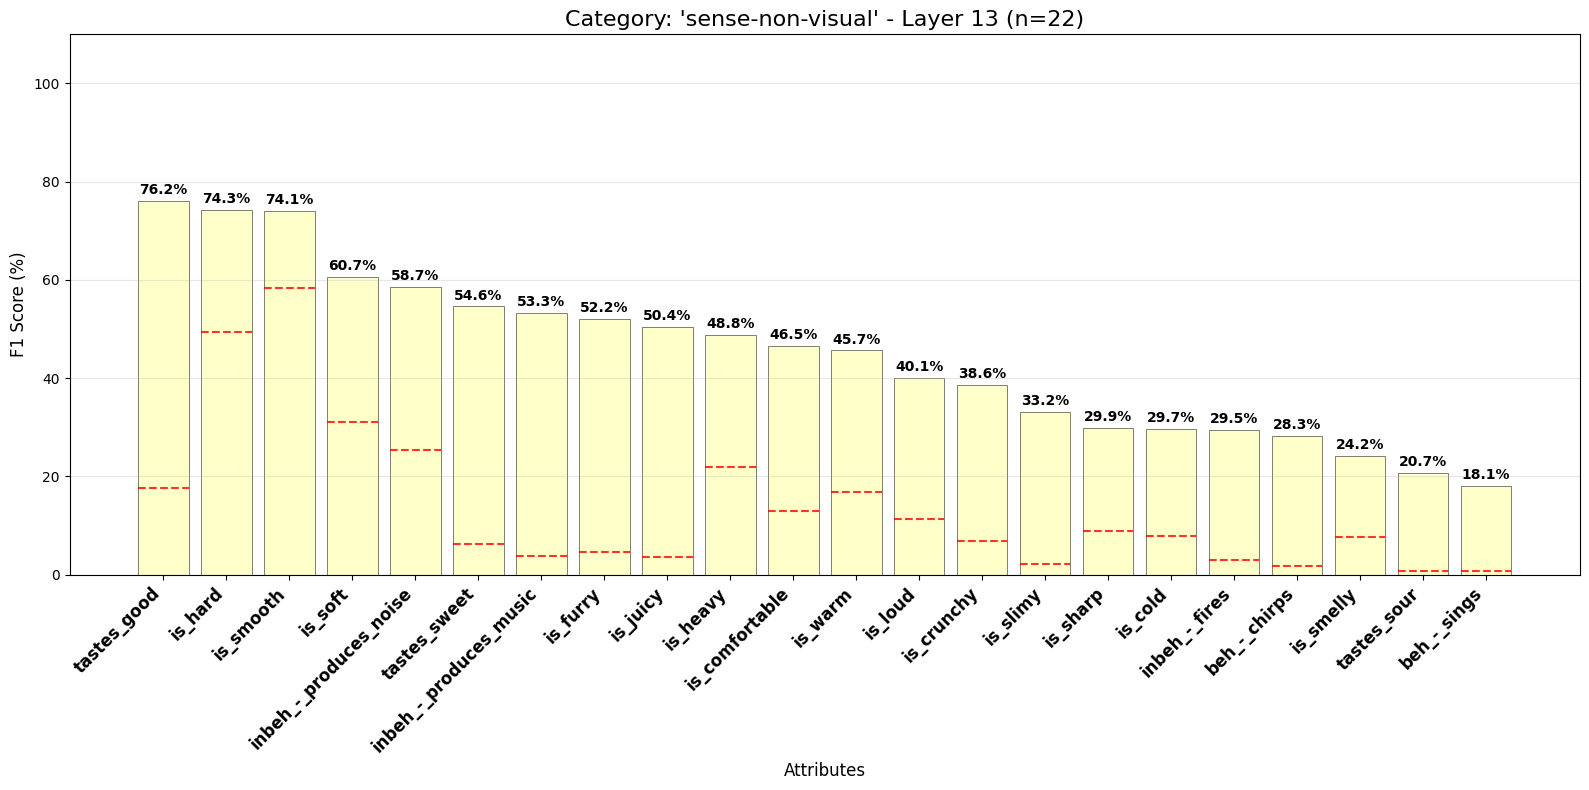


Single Category Analysis: 'sense-non-visual' (Layer 13)
Number of attributes: 22
Mean F1 score: 44.9% ± 16.9%
Mean baseline: 13.8% ± 15.1%
Mean improvement: 31.1% ± 11.6%
Best attribute: tastes_good (76.2%)
Worst attribute: beh_-_sings (18.1%)
Performance range: 18.1% - 76.2%

All attributes in 'sense-non-visual':
   1. tastes_good                   : 76.2% (baseline: 17.7%, improvement: +58.4%)
   2. is_hard                       : 74.3% (baseline: 49.4%, improvement: +24.9%)
   3. is_smooth                     : 74.1% (baseline: 58.3%, improvement: +15.8%)
   4. is_soft                       : 60.7% (baseline: 31.1%, improvement: +29.5%)
   5. inbeh_-_produces_noise        : 58.7% (baseline: 25.3%, improvement: +33.4%)
   6. tastes_sweet                  : 54.6% (baseline: 6.2%, improvement: +48.4%)
   7. inbeh_-_produces_music        : 53.3% (baseline: 3.7%, improvement: +49.5%)
   8. is_furry                      : 52.2% (baseline: 4.7%, improvement: +47.4%)
   9. is_juicy        

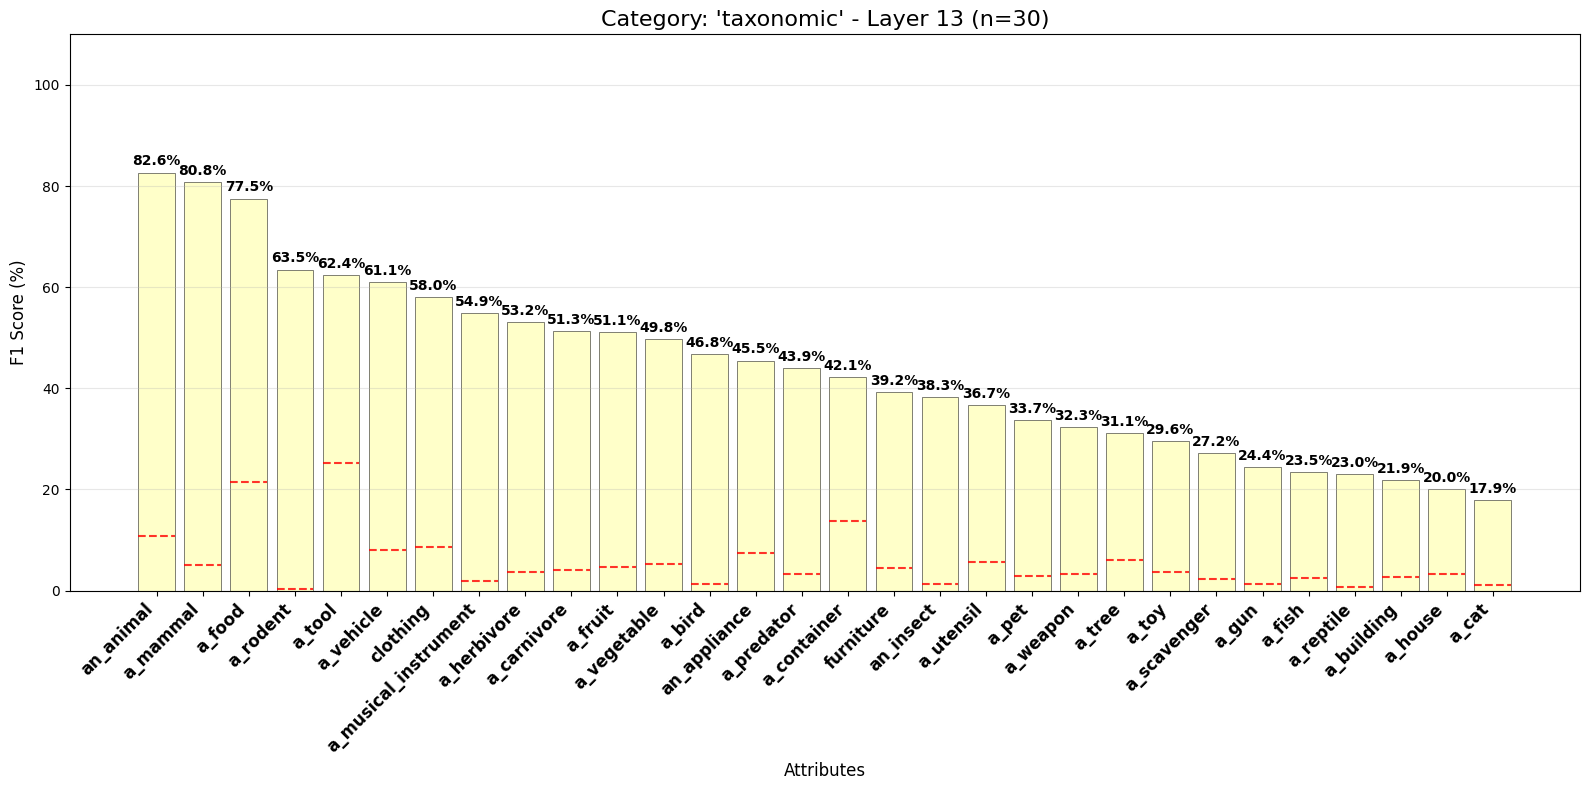


Single Category Analysis: 'taxonomic' (Layer 13)
Number of attributes: 30
Mean F1 score: 44.1% ± 17.8%
Mean baseline: 5.5% ± 5.6%
Mean improvement: 38.6% ± 15.6%
Best attribute: an_animal (82.6%)
Worst attribute: a_cat (17.9%)
Performance range: 17.9% - 82.6%

All attributes in 'taxonomic':
   1. an_animal                     : 82.6% (baseline: 10.7%, improvement: +71.9%)
   2. a_mammal                      : 80.8% (baseline: 5.0%, improvement: +75.8%)
   3. a_food                        : 77.5% (baseline: 21.4%, improvement: +56.1%)
   4. a_rodent                      : 63.5% (baseline: 0.2%, improvement: +63.2%)
   5. a_tool                        : 62.4% (baseline: 25.2%, improvement: +37.1%)
   6. a_vehicle                     : 61.1% (baseline: 8.1%, improvement: +53.0%)
   7. clothing                      : 58.0% (baseline: 8.6%, improvement: +49.4%)
   8. a_musical_instrument          : 54.9% (baseline: 1.9%, improvement: +53.1%)
   9. a_herbivore                   : 53.2% (bas

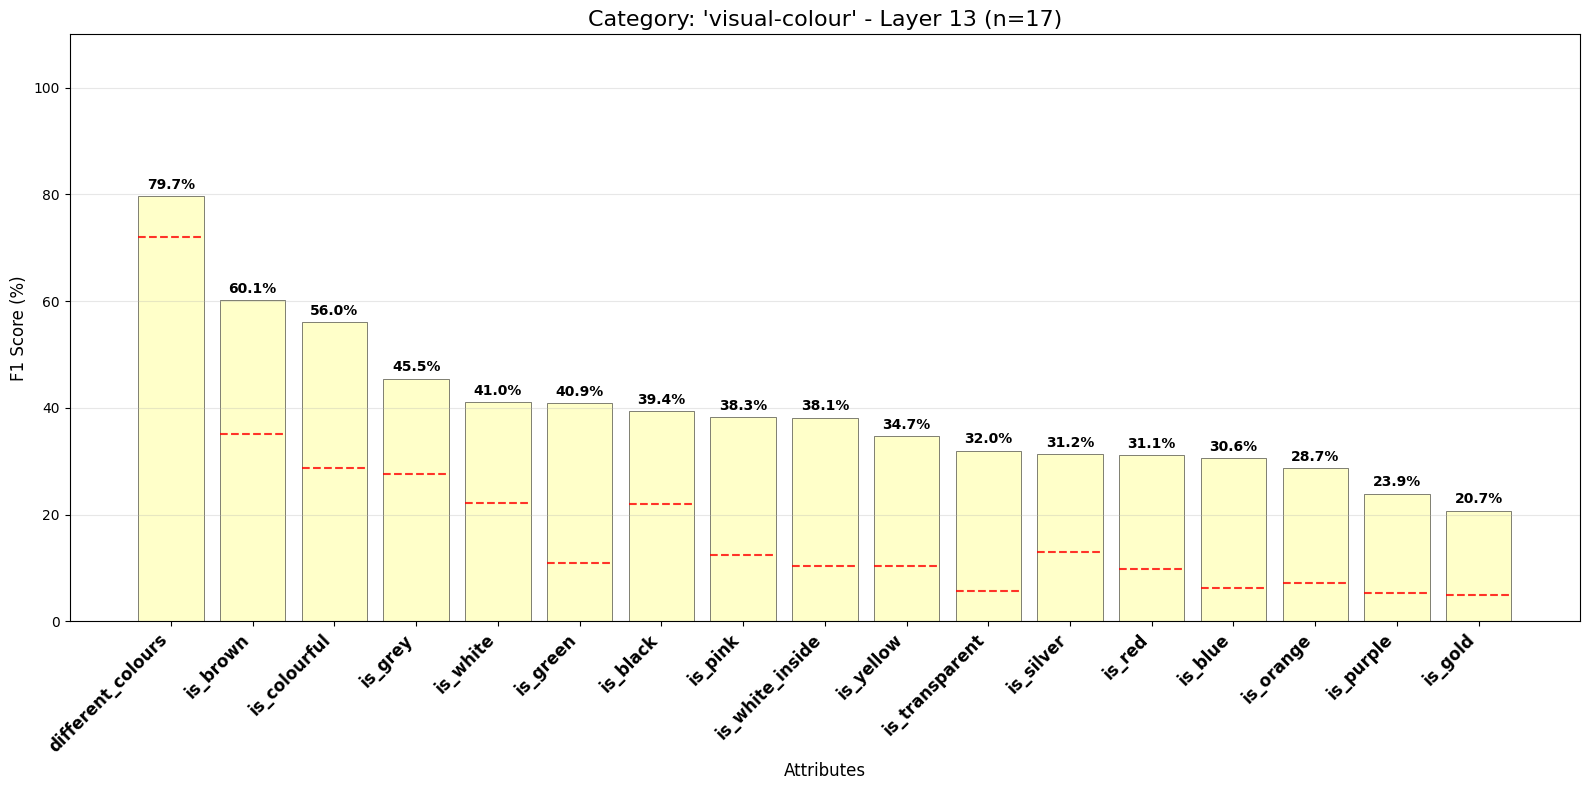


Single Category Analysis: 'visual-colour' (Layer 13)
Number of attributes: 17
Mean F1 score: 39.5% ± 14.1%
Mean baseline: 17.9% ± 16.3%
Mean improvement: 21.7% ± 5.4%
Best attribute: different_colours (79.7%)
Worst attribute: is_gold (20.7%)
Performance range: 20.7% - 79.7%

All attributes in 'visual-colour':
   1. different_colours             : 79.7% (baseline: 72.1%, improvement: +7.6%)
   2. is_brown                      : 60.1% (baseline: 35.1%, improvement: +25.0%)
   3. is_colourful                  : 56.0% (baseline: 28.8%, improvement: +27.3%)
   4. is_grey                       : 45.5% (baseline: 27.6%, improvement: +17.8%)
   5. is_white                      : 41.0% (baseline: 22.2%, improvement: +18.8%)
   6. is_green                      : 40.9% (baseline: 10.8%, improvement: +30.1%)
   7. is_black                      : 39.4% (baseline: 21.9%, improvement: +17.5%)
   8. is_pink                       : 38.3% (baseline: 12.4%, improvement: +25.9%)
   9. is_white_inside    

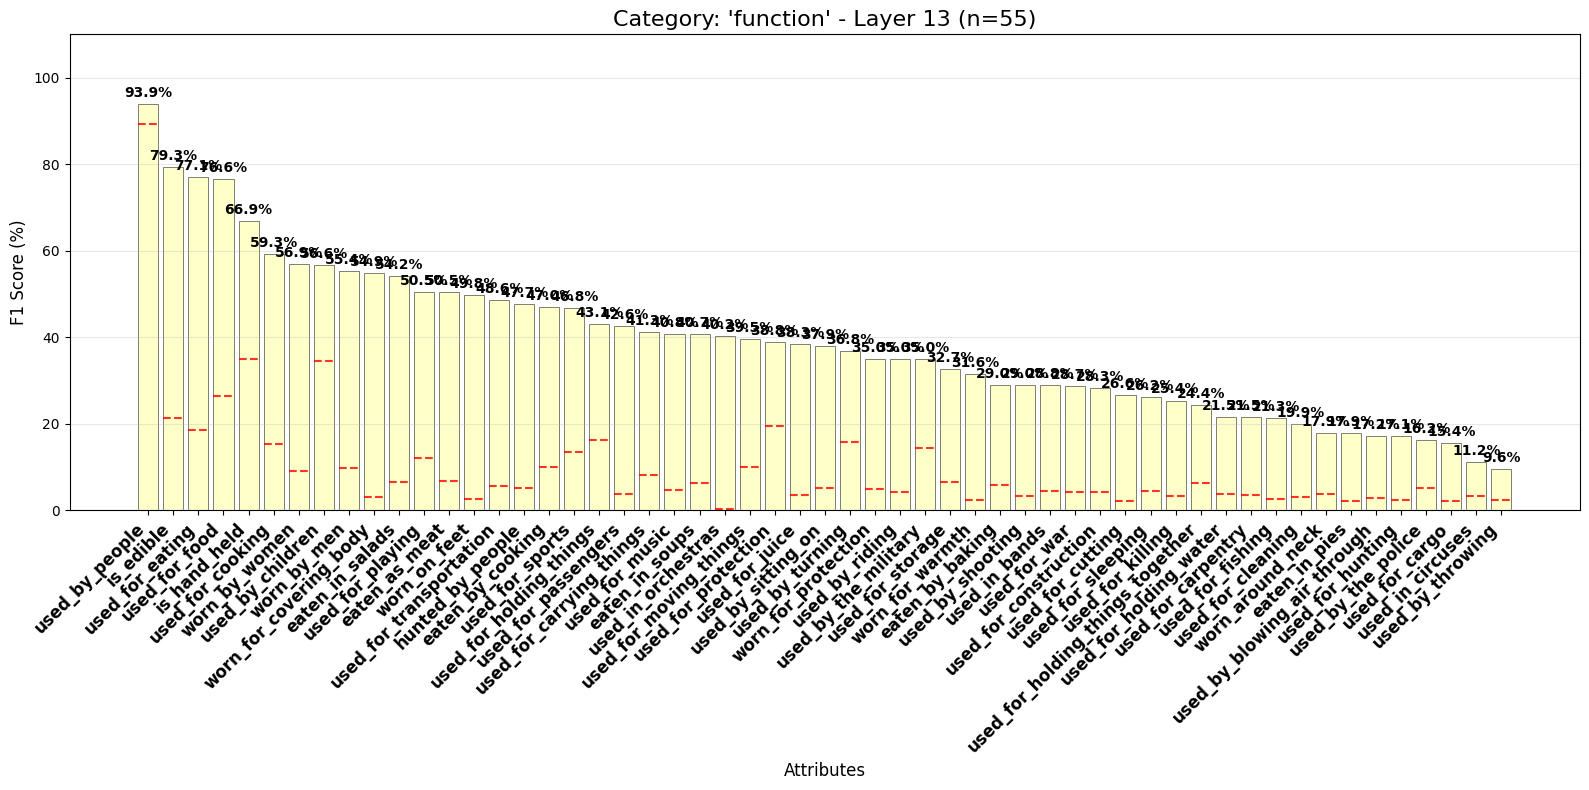


Single Category Analysis: 'function' (Layer 13)
Number of attributes: 55
Mean F1 score: 38.8% ± 18.1%
Mean baseline: 9.6% ± 13.2%
Mean improvement: 29.2% ± 13.1%
Best attribute: used_by_people (93.9%)
Worst attribute: used_by_throwing (9.6%)
Performance range: 9.6% - 93.9%

All attributes in 'function':
   1. used_by_people                : 93.9% (baseline: 89.4%, improvement: +4.5%)
   2. is_edible                     : 79.3% (baseline: 21.4%, improvement: +57.9%)
   3. used_for_eating               : 77.1% (baseline: 18.5%, improvement: +58.6%)
   4. used_for_food                 : 76.6% (baseline: 26.4%, improvement: +50.2%)
   5. is_hand_held                  : 66.9% (baseline: 34.9%, improvement: +31.9%)
   6. used_for_cooking              : 59.3% (baseline: 15.3%, improvement: +43.9%)
   7. worn_by_women                 : 56.9% (baseline: 9.2%, improvement: +47.7%)
   8. used_by_children              : 56.6% (baseline: 34.6%, improvement: +22.0%)
   9. worn_by_men               

[('used_by_people', 93.92244467041752, 89.37827870192628, 'function'),
 ('is_edible', 79.27070673495487, 21.416943699610712, 'function'),
 ('used_for_eating', 77.11228748764853, 18.462924071466258, 'function'),
 ('used_for_food', 76.63624408311478, 26.447571027932813, 'function'),
 ('is_hand_held', 66.85994629744718, 34.94977330855475, 'function'),
 ('used_for_cooking', 59.268781321160105, 15.320832101743465, 'function'),
 ('worn_by_women', 56.89875206282573, 9.189483797420642, 'function'),
 ('used_by_children', 56.58339655086022, 34.55162499340369, 'function'),
 ('worn_by_men', 55.356383791754396, 9.722867719966692, 'function'),
 ('worn_for_covering_body', 54.90737199155631, 3.115329228017935, 'function'),
 ('eaten_in_salads', 54.22653991930304, 6.517228692503951, 'function'),
 ('used_for_playing', 50.49447259385087, 12.191598444437233, 'function'),
 ('eaten_as_meat', 50.458453346911256, 6.815228973785656, 'function'),
 ('worn_on_feet', 49.761203504011604, 2.5298293515530026, 'functio

In [31]:
def single_category_breakdown(results, layer, taxonomy, category, metric="f1", save_path=None, save_csv=True):
    """Plot individual attributes for a single category as bars, similar to attribute_breakdown."""
    if layer not in results:
        print(f"Layer {layer} not found in results")
        return

    # Get all attribute scores for this layer
    individual_results = results[layer]["individual_results"]

    # Filter for the specified category only
    category_attrs = []
    for result in individual_results:
        attr = result["attribute"]
        attr_category = taxonomy.get(attr, "unknown")
        
        # Check if this attribute belongs to the specified category
        # Support partial matching (e.g., "taxonomic" matches attributes with "taxonomic" in their category)
        if category.lower() in attr_category.lower() or attr_category.lower() == category.lower():
            score = result[f"mean_{metric}"] * 100  # Convert to percentage
            baseline = result[f"baseline_mean_{metric}"] * 100
            category_attrs.append((attr, score, baseline, attr_category))

    if not category_attrs:
        print(f"No attributes found for category '{category}' in layer {layer}")
        available_categories = set([taxonomy.get(r["attribute"], "unknown") for r in individual_results])
        print(f"Available categories: {sorted(available_categories)}")
        return

    # Sort by score (descending)
    category_attrs.sort(key=lambda x: x[1], reverse=True)

    # Extract data for plotting
    attributes = [attr for attr, _, _, _ in category_attrs]
    scores = [score for _, score, _, _ in category_attrs]
    baselines = [baseline for _, _, baseline, _ in category_attrs]

    # Save to CSV if requested
    if save_csv:
        import pandas as pd
        
        # Create DataFrame
        df = pd.DataFrame({
            'attribute': attributes,
            'score': scores,
            'baseline': baselines,
            'category': [cat for _, _, _, cat in category_attrs],
            'improvement': [score - baseline for score, baseline in zip(scores, baselines)]
        })
        
        # Generate CSV filename
        if save_path:
            csv_path = save_path.replace('.png', '.csv')
        else:
            csv_path = f"{SAVE_DIR}/single_category_{category.replace(' ', '_').replace('-', '_')}_layer{layer}.csv"
        
        # Save CSV
        df.to_csv(csv_path, index=False)
        print(f"Saved CSV to: {csv_path}")

    # Create the plot
    plt.figure(figsize=(16, 8))
    x_pos = range(len(attributes))
    
    # Use a single color for the category
    bar_color = plt.cm.Set3(0.1)  # You can adjust this color

    # Create bars
    bars = plt.bar(
        x_pos,
        scores,
        color=bar_color,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    # Add percentage labels on top of bars
    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(scores) * 0.01,
            f"{score:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Add baseline markers
    for i, baseline in enumerate(baselines):
        plt.plot(
            [i - 0.4, i + 0.4],
            [baseline, baseline],
            color="red",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
        )

    # Formatting
    plt.xlabel("Attributes", fontsize=12)
    plt.ylabel(f"{metric.upper()} Score (%)", fontsize=12)
    plt.title(
        f"Category: '{category}' - Layer {layer} (n={len(attributes)})",
        fontsize=16,
    )
    plt.grid(True, alpha=0.3, axis="y")

    # Set x-axis labels
    plt.xticks(x_pos, attributes, rotation=45, ha="right", fontsize=12, fontweight='bold')
    plt.ylim(0, 110)
    
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to: {save_path}")

    plt.show()

    # Print summary statistics
    print(f"\nSingle Category Analysis: '{category}' (Layer {layer})")
    print("=" * 60)
    print(f"Number of attributes: {len(attributes)}")
    print(f"Mean {metric.upper()} score: {np.mean(scores):.1f}% ± {np.std(scores):.1f}%")
    print(f"Mean baseline: {np.mean(baselines):.1f}% ± {np.std(baselines):.1f}%")
    print(f"Mean improvement: {np.mean([s-b for s,b in zip(scores, baselines)]):.1f}% ± {np.std([s-b for s,b in zip(scores, baselines)]):.1f}%")
    print(f"Best attribute: {attributes[0]} ({scores[0]:.1f}%)")
    print(f"Worst attribute: {attributes[-1]} ({scores[-1]:.1f}%)")
    print(f"Performance range: {min(scores):.1f}% - {max(scores):.1f}%")
    
    print(f"\nAll attributes in '{category}':")
    for i, (attr, score, baseline, cat) in enumerate(category_attrs, 1):
        improvement = score - baseline
        print(f"  {i:2d}. {attr:<30}: {score:.1f}% (baseline: {baseline:.1f}%, improvement: {improvement:+.1f}%)")

    return category_attrs


# Example usage: Plot attributes for a specific category
# Change the category name below to analyze different categories
target_category = "visual-colour"  # Change this to your desired category

# if taxonomy and results and 'best_layer' in locals():
#     print(f"Available categories in taxonomy: {sorted(set(taxonomy.values()))}")
    
#     save_path = f"{SAVE_DIR}/single_category_{target_category}_layer{best_layer}.png" if SAVE_PLOTS else None
#     single_category_breakdown(results, best_layer, taxonomy, target_category, save_path=save_path, save_csv=True)
# else:
#     print("Skipping single category analysis - no taxonomy, results, or best layer identified")

single_category_breakdown(results, 13, taxonomy, "encyclopaedic", save_csv=True)
single_category_breakdown(results, 13, taxonomy, "visual-form_and_surface", save_csv=True)
single_category_breakdown(results, 13, taxonomy, "visual-motion", save_csv=True)
single_category_breakdown(results, 13, taxonomy, "sense-non-visual", save_csv=True)
single_category_breakdown(results, 13, taxonomy, "taxonomic", save_csv=True)
single_category_breakdown(results, 13, taxonomy, "visual-colour", save_csv=True)
single_category_breakdown(results, 13, taxonomy, "function", save_csv=True)

## 6. Single Category Analysis

In [20]:
# Generate comprehensive summary
if results:
    print("\n" + "="*60)
    print("PROBE ANALYSIS SUMMARY")
    print("="*60)
    
    # Overall statistics
    total_layers = len(results)
    layer_data = extract_layer_performance(results, "f1")
    
    if layer_data:
        best_layer_data = max(layer_data, key=lambda x: x['mean'])
        worst_layer_data = min(layer_data, key=lambda x: x['mean'])
        avg_performance = np.mean([d['mean'] for d in layer_data])
        
        print(f"\nDataset Overview:")
        print(f"- Total layers analyzed: {total_layers}")
        print(f"- Average attributes per layer: {np.mean([d['n_attributes'] for d in layer_data]):.0f}")
        print(f"- Performance range: {worst_layer_data['mean']:.1f}% - {best_layer_data['mean']:.1f}%")
        print(f"- Average performance: {avg_performance:.1f}%")
        
        print(f"\nKey Findings:")
        print(f"- Best performing layer: {best_layer_data['layer']} ({best_layer_data['mean']:.1f}% F1)")
        print(f"- Worst performing layer: {worst_layer_data['layer']} ({worst_layer_data['mean']:.1f}% F1)")
        print(f"- Performance improvement: {best_layer_data['mean'] - worst_layer_data['mean']:.1f}% from worst to best")
        
        if taxonomy:
            print(f"\nCategory Analysis:")
            print(f"- Total categories: {len(set(taxonomy.values()))}")
            print(f"- Categories: {', '.join(sorted(set(taxonomy.values())))}")
            
            if 'category_peaks' in locals():
                print(f"\nCategory Peak Performance:")
                for cat, peak in sorted(category_peaks.items(), key=lambda x: x[1]['score'], reverse=True):
                    print(f"- {cat}: {peak['score']:.1f}% at layer {peak['layer']}")
    
    print(f"\nRecommendations:")
    if 'best_layer_data' in locals():
        print(f"- Use layer {best_layer_data['layer']} for optimal probe performance")
        print(f"- Consider layers around {best_layer_data['layer']} for fine-tuning")
        
    if SAVE_PLOTS:
        print(f"\nAll plots saved to: {SAVE_DIR}")
        
else:
    print("\nNo results to summarize. Please check your RESULTS_DIR configuration.")


PROBE ANALYSIS SUMMARY

Dataset Overview:
- Total layers analyzed: 14
- Average attributes per layer: 278
- Performance range: 3.5% - 49.7%
- Average performance: 26.8%

Key Findings:
- Best performing layer: 11 (49.7% F1)
- Worst performing layer: 0 (3.5% F1)
- Performance improvement: 46.2% from worst to best

Category Analysis:
- Total categories: 7
- Categories: encyclopaedic, function, sense-non-visual, taxonomic, visual-colour, visual-form_and_surface, visual-motion

Category Peak Performance:
- visual-motion: 55.9% at layer 11
- visual-form_and_surface: 53.1% at layer 11
- taxonomic: 53.1% at layer 11
- encyclopaedic: 52.6% at layer 11
- sense-non-visual: 48.9% at layer 11
- function: 41.2% at layer 11
- visual-colour: 40.9% at layer 11

Recommendations:
- Use layer 11 for optimal probe performance
- Consider layers around 11 for fine-tuning

All plots saved to: ../plots/notebook_analysis
